In [44]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from mne.decoding import CSP
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [45]:
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230622'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']
# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []
o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ
all_data = list()  # 全データを結合
file_name = list()  # すべての.matファイルの名前

In [46]:
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)
#解析するデータを選択
#file_name1 = [file_name[2],file_name[9],file_name[3],file_name[4]]
file_name1 = [file_name[5],file_name[6],file_name[7],file_name[8]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:66, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")
print(file_name1)

Filelist
['EEG_grasping_22-Jun-2023_sub1-1.mat', 'EEG_grasping_22-Jun-2023_sub1-2.mat', 'EEG_grasping_22-Jun-2023_sub2-1.mat', 'EEG_grasping_22-Jun-2023_sub2-2.mat', 'EEG_grasping_22-Jun-2023_sub2-3.mat', 'EEG_grasping_22-Jun-2023_sub3-1.mat', 'EEG_grasping_22-Jun-2023_sub3-2.mat', 'EEG_grasping_22-Jun-2023_sub3-3.mat', 'EEG_grasping_22-Jun-2023_sub3-4.mat', 'EEG_grasping_22-Jun-2023_sub2-4.mat']
image data_loading
['EEG_grasping_22-Jun-2023_sub3-1.mat', 'EEG_grasping_22-Jun-2023_sub3-2.mat', 'EEG_grasping_22-Jun-2023_sub3-3.mat', 'EEG_grasping_22-Jun-2023_sub3-4.mat']


In [47]:
#eeg_data
c1 = o_data65_label1[0].eeg[0:64 , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[0:64 , 0:10240]
    c1 = np.dstack([c1, g1])
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)
#label
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
label_data = np.array(label_data)
print(np.shape(label_data))

(120, 64, 10240)
(120,)


In [48]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('standard_1020')

events = np.column_stack(
    (
        np.arange(0, 1024*120, sampling_freq),
        np.zeros(120, dtype=int),
        label_data
    )
)
event_dict = dict(condition_A=1, condition_B=2)
simulated_epochs = mne.EpochsArray(
    all_data, info, tmin=-6, events=events, event_id=event_dict)

Not setting metadata
120 matching events found


No baseline correction applied
0 projection items activated


Setting up band-pass filter from 2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:    0.7s finished


Selecting by number: 20 components
Fitting ICA took 3.0s.


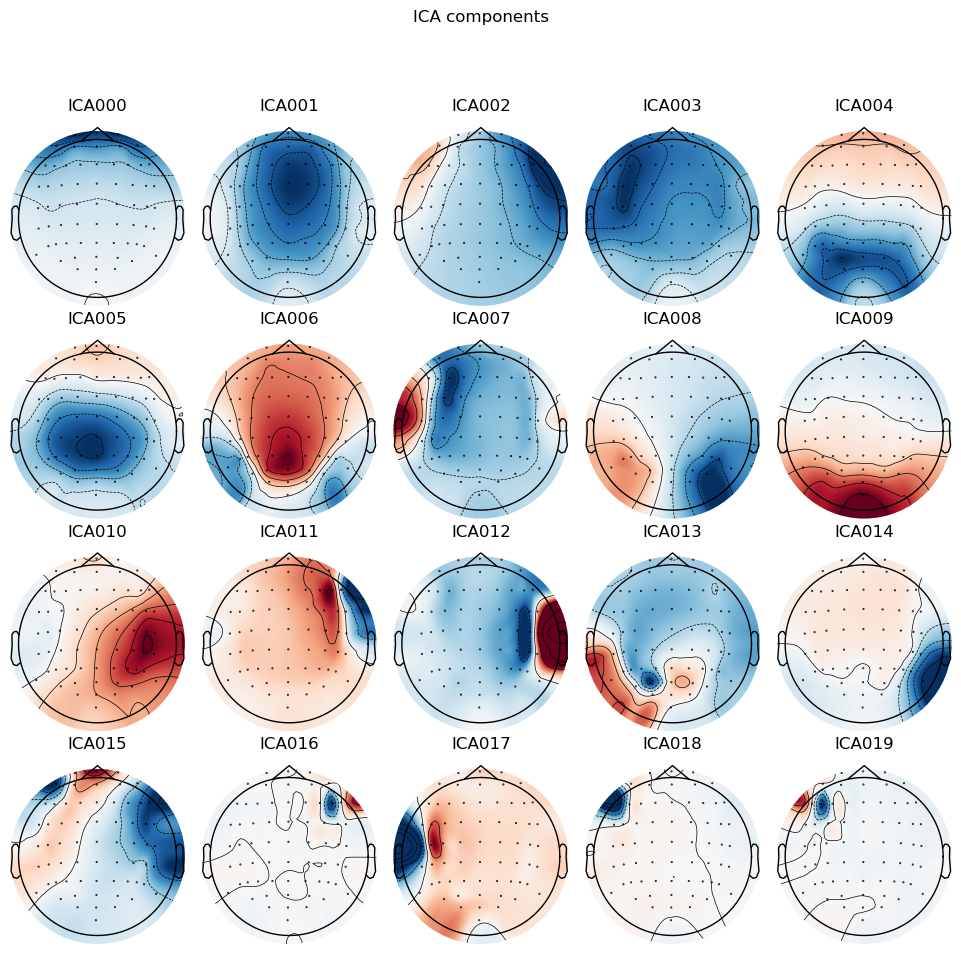

[<MNEFigure size 975x967 with 20 Axes>]

In [49]:
resample_freq = 100
resample_epochs = simulated_epochs.resample(sfreq=resample_freq)
data_flit = resample_epochs.filter(l_freq=2.0,h_freq=30)
ica = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter=800)
ica.fit(data_flit)
ica.plot_components()

In [50]:
from mne_icalabel import label_components
label_components(data_flit, ica, method='iclabel')

/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_6510/2271117657.py:2: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  label_components(data_flit, ica, method='iclabel')
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_6510/2271117657.py:2: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  label_components(data_flit, ica, method='iclabel')
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_6510/2271117657.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax I

{'y_pred_proba': array([0.9486278 , 0.9207862 , 0.50496376, 0.70221263, 0.9992496 ,
        0.99954194, 0.9963599 , 0.52261853, 0.991571  , 0.9429525 ,
        0.9756631 , 0.5985908 , 0.94296443, 0.9936005 , 0.92333245,
        0.8285679 , 0.40527374, 0.79025334, 0.40678152, 0.38683474],
       dtype=float32),
 'labels': ['eye blink',
  'brain',
  'other',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'muscle artifact',
  'muscle artifact',
  'brain',
  'brain',
  'other',
  'brain',
  'muscle artifact',
  'brain',
  'other']}

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


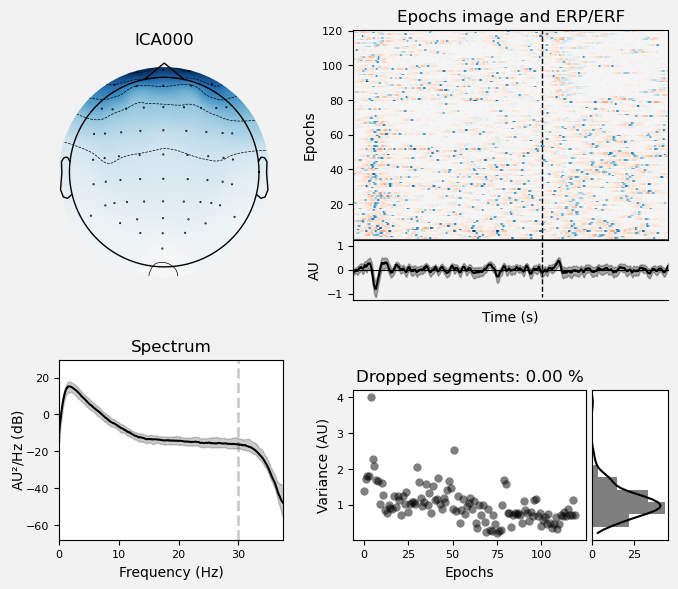

[<Figure size 700x600 with 6 Axes>]

In [51]:
#6/20
ica.exclude = [0]
#6/29
#ica.exclude = [0,7,16]
#7/13
#ica.exclude = [0,2,4,5,19]
#7/20
#ica.exclude = [0,2,5,18]
#7/21
#ica.exclude = [2,19]
ica.plot_properties(data_flit,picks=ica.exclude)

In [52]:
#選択したICAの除去
data_ica = data_flit.copy()
ica.apply(data_ica)
data_ica.apply_baseline(baseline=(-6,-3))


Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Applying baseline correction (mode: mean)


Number of events,120
Events,condition_A: 60condition_B: 60
Time range,-6.000 – 3.990 sec
Baseline,-6.000 – -3.000 sec


In [53]:
# #ラプラシアンフィルタの適用
# data_ica_csd = mne.preprocessing.compute_current_source_density(data_ica)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_6510/1857669653.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  data_ica.compute_psd(fmax=50).plot().show()


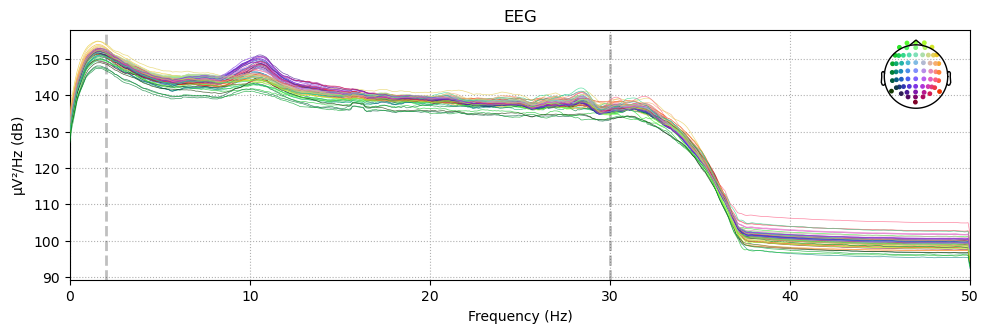

In [54]:
data_ica.compute_psd(fmax=50).plot().show()

In [55]:
motorbrainAdress = ['FC3','FC1','C1','C3','C5','CP3','CP1','CPz','FC4','FC2',
'FCz','Cz','C2','C4','C6','CP4','CP2',]
# info_motor = mne.create_info(ch_names=motorbrainAdress, ch_types="eeg", sfreq=1024)
# info_motor.set_montage('standard_1020')

In [56]:
#データをnumpyに変換
data_numpy = data_ica.get_data()
print(np.shape(data_numpy))

# motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]
# data_numpy_task  = data_numpy[:,motor_brainAdress,100*6:100*10]

(120, 64, 1000)


In [57]:
np.save('numpy_data/subject1_data2', data_numpy)
np.save('numpy_data/subject1_label2', label_data)
